<a href="https://colab.research.google.com/github/RicardColomOrero/easymoney/blob/main/Easymoney.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ENUNCIADO CAPSTONE

 
## 1.- PowerBI (Opcional)
Hemos decidido reorientar nuestra estrategia comercial hacia el
**aumento de la penetración de la cartera actual de productos en nuestro mercado**, con la idea de obtener una
mejor rentabilidad de nuestra base actual de clientes (lo del cuadrante barato de la matriz de Ansoff). 

A cambio, reduciremos la actividad intensiva de captación que veníamos realizando desde que arrancamos. En este sentido, y para acabar de definir la estrategia, estaría genial poder tener algunos análisis que nos ayuden
a tomar decisiones. Como te decía, ahora tenemos un autoservicio, pero esta foto simple no nos ayuda demasiado. 
Si ni siquiera sé cuantos productos hemos vendido este mes o si son los clientes nuevos quiénes contratan o los que ya teníamos!

Sería genial incluso que pudieses utilizar el reciente producto adquirido
PowerBI para **preparar unos KPI’s de lo que tenemos en la empresa**

## 2.- Propensión (modelo de propensión a compra)

Una vez que hayamos hecho el **análisis de nuestra BBDD nos gustaría poder vender más y mejor nuestros productos**, sé que los data scientist tienen una “bola de cristal” y saben qué clientes son más propensos a
comprar nuestros productos así que te pido por favor hagas un **modelo de propensión a compra**, se que tenemos muchos productos, así que te **,dejo a tu criterio científico qué productos elegir, o pueden ser varios,**, ya
me sorprenderás

## 3.- Segmentación

Una vez obtenido la propensión de los productos sería genial poder conocer mejor a nuestros clientes para orientar nuestra actividad comercial. Hace tiempo vengo teniendo la idea de que podríamos **segmentar la base
de clientes en 7 u 8 grupos de clientes similares**... sería genial** identificarlos, y poder saber cómo son los clientes
que pertenecen a estos grupos**... nos ayudaría muchísimo a la hora de definir todo nuestro plan de marketing de cara a futuro!

## 4.- Caso de uso

Perfecto! Tenemos las segmentaciones de clientes, tenemos las propensiones y ahora lo que nos falta es realizar
**un caso de uso que nos permita estimar en base a una campaña X cuánto dinero podemos ganar**, 

¿A cuántos clientes tenemos que impactar?

¿Qué productos ofrecer?
 
¿Impactamos a todos lo segmentos indicados?


# Importación de librerías

In [12]:
import numpy as np # Arrays
import pandas as pd # Series and Dataframes

from google.colab import files

#visualizacion
import matplotlib.pyplot as plt 
import seaborn as sns 

pd.options.display.max_rows = 200
plt.style.use('ggplot') # Beautify Plots 

#Modelling
from sklearn import model_selection
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
import graphviz


In [13]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Importación dataset

In [14]:
#EVA file_dir = "/content/drive/MyDrive/TFM  Data Science/datasets_TFM_y_diccionario/"
file_dir = "/content/drive/MyDrive/Master_DS/TFM_Data_Science/datasets_TFM_y_diccionario/" #Culebra file_dir

In [15]:
file_sales ="sales.csv"
file_product_description ="product_description.csv"
file_customer_sociodemographics ="customer_sociodemographics.csv"
file_customer_commercial_activity = "customer_commercial_activity.csv"
file_customer_products ="customer_products.csv"

In [16]:
sales_raw = pd.read_csv(file_dir + file_sales)
product_description_raw = pd.read_csv(file_dir +file_product_description)
customer_sociodemographics_raw = pd.read_csv(file_dir + file_customer_sociodemographics)
customer_commercial_activity_raw = pd.read_csv(file_dir + file_customer_commercial_activity)
customer_products_raw = pd.read_csv(file_dir + file_customer_products)

# 2.- DATA UNDERSTANDING

## 2.1.- Análisis univariante de datos

### Sales

* pk_sale: Identificador de venta - (primary key)
* cid: Identificador de cliente - (foreing key)
* month_sale: Mes de venta. Mes en el que se contrata un producto.
* product_ID: Identificador de producto  - (foreing key)
* net_margin: Margen neto generado por la venta ($)

In [17]:
# Análisis inicial de sales

sales_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240773 entries, 0 to 240772
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Unnamed: 0  240773 non-null  int64  
 1   pk_sale     240773 non-null  int64  
 2   cid         240773 non-null  int64  
 3   month_sale  240773 non-null  object 
 4   product_ID  240773 non-null  int64  
 5   net_margin  240773 non-null  float64
dtypes: float64(1), int64(4), object(1)
memory usage: 11.0+ MB


In [18]:
sales_raw.head()

,Unnamed: 0,pk_sale,cid,month_sale,product_ID,net_margin
0,0,6666,33620,2018-05-01,2335,952.9
1,1,6667,35063,2018-06-01,2335,1625.2
2,2,6668,37299,2018-02-01,2335,1279.7
3,3,6669,39997,2018-02-01,2335,1511.9
4,4,6670,44012,2018-02-01,2335,1680.3


In [19]:
sales_raw.describe(include = ['object'])

,month_sale
count,240773
unique,16
top,2018-10-01
freq,27693


In [20]:
sales_raw.describe(exclude = ['object'])

,Unnamed: 0,pk_sale,cid,product_ID,net_margin
count,240773.000000,240773.000000,2.407730e+05,240773.000000,240773.000000
mean,120386.000000,127052.000000,1.363934e+06,3945.408202,606.878164
std,69505.322519,69505.322519,1.751721e+05,1632.821700,1735.806089
min,0.000000,6666.000000,1.589100e+04,1119.000000,25.000000
25%,60193.000000,66859.000000,1.301012e+06,2312.000000,61.400000
50%,120386.000000,127052.000000,1.409253e+06,4657.000000,69.100000
75%,180579.000000,187245.000000,1.475320e+06,4657.000000,79.200000
max,240772.000000,247438.000000,1.553571e+06,9001.000000,18466.400000


In [21]:
sales_raw.isnull().sum()

Unnamed: 0    0
pk_sale       0
cid           0
month_sale    0
product_ID    0
net_margin    0
dtype: int64

In [22]:
sales_raw[sales_raw.duplicated()]

,Unnamed: 0,pk_sale,cid,month_sale,product_ID,net_margin


In [ ]:
# ACCIONES A LLEVAR A CABO 

# Eliminar columna Unnamed
# Renombrar columnas para alinear el naming, por ejemplo variable cid como "client_ID", pk_sale como "sale_ID"
# Cambiar los identificadores (product_ID, customer_ID) a variable categórica
# Cambiar tipo de month_sale a fecha
# Disgregar la fecha en mes, año... (otros: trimestre, fin de semana, festivo...)


### Product Description

* pk_product_ID	= Identificador de producto - (primary key)
* product_desc	= Descripción del producto
* family_product	= Vertical del producto. Grupo al que pertenece.

In [23]:
# Análisis inicial de product description

product_description_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13 entries, 0 to 12
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Unnamed: 0      13 non-null     int64 
 1   pk_product_ID   13 non-null     int64 
 2   product_desc    13 non-null     object
 3   family_product  13 non-null     object
dtypes: int64(2), object(2)
memory usage: 544.0+ bytes


In [24]:
product_description_raw

,Unnamed: 0,pk_product_ID,product_desc,family_product
0,0,4657,em_acount,account
1,1,3819,debit_card,payment_card
2,2,1364,pension_plan,pension_plan
3,3,2234,payroll,account
4,4,2235,payroll_account,account
5,5,8871,emc_account,account
6,6,2312,credit_card,payment_card
7,7,2335,short_term_deposit,investment
8,8,2336,long_term_deposit,investment
9,9,2673,securities,investment


In [25]:
product_description_raw.describe(include = ['object'])

,product_desc,family_product
count,13,13
unique,13,5
top,em_acount,account
freq,1,4


In [26]:
product_description_raw.describe(exclude = ['object'])

,Unnamed: 0,pk_product_ID
count,13.00000,13.000000
mean,6.00000,3614.538462
std,3.89444,2564.251438
min,0.00000,1119.000000
25%,3.00000,2235.000000
50%,6.00000,2336.000000
75%,9.00000,4033.000000
max,12.00000,9001.000000


In [27]:
product_description_raw.isnull().sum()

Unnamed: 0        0
pk_product_ID     0
product_desc      0
family_product    0
dtype: int64

In [28]:
product_description_raw[product_description_raw.duplicated()]

,Unnamed: 0,pk_product_ID,product_desc,family_product


In [29]:
# ACCIONES A LLEVAR A CABO 

# Eliminar columna Unnamed

### Customer Sociodemographics

* pk_cid =	Identificador de cliente
* pk_partition =	Identificador de Partición. Mensualmente se ingesta en la tabla una partición con el estado de la base de clientes.
* deceased =	Indicador de fallecimiento
* gender =	Sexo del cliente
* region_code =	Provincia de residencia del cliente (para ES)
* salary =	Ingresos brutos de la unidad familiar
* country_id =	País de residencia del cliente
* age =	Edad del cliente

In [30]:
customer_sociodemographics_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5962924 entries, 0 to 5962923
Data columns (total 9 columns):
 #   Column        Dtype  
---  ------        -----  
 0   Unnamed: 0    int64  
 1   pk_cid        int64  
 2   pk_partition  object 
 3   country_id    object 
 4   region_code   float64
 5   gender        object 
 6   age           int64  
 7   deceased      object 
 8   salary        float64
dtypes: float64(2), int64(3), object(4)
memory usage: 409.4+ MB


In [31]:
customer_sociodemographics_raw.head()

,Unnamed: 0,pk_cid,pk_partition,country_id,region_code,gender,age,deceased,salary
0,0,1375586,2018-01,ES,29.0,H,35,N,87218.10
1,1,1050611,2018-01,ES,13.0,V,23,N,35548.74
2,2,1050612,2018-01,ES,13.0,V,23,N,122179.11
3,3,1050613,2018-01,ES,50.0,H,22,N,119775.54
4,4,1050614,2018-01,ES,50.0,V,23,N,NaN


In [32]:
customer_sociodemographics_raw.describe(include = ['object'])

,pk_partition,country_id,gender,deceased
count,5962924,5962924,5962899,5962924
unique,17,41,2,2
top,2019-05,ES,H,N
freq,442995,5960672,3087502,5961849


In [33]:
customer_sociodemographics_raw.describe(exclude = ['object'])

,Unnamed: 0,pk_cid,region_code,age,salary
count,5.962924e+06,5.962924e+06,5.960660e+06,5.962924e+06,4.421820e+06
mean,7.155425e+06,1.234930e+06,2.581440e+01,2.976042e+01,1.155833e+05
std,3.920784e+06,1.623020e+05,1.359566e+01,1.198038e+01,2.000066e+05
min,0.000000e+00,1.589100e+04,1.000000e+00,2.000000e+00,1.202730e+03
25%,4.240386e+06,1.112532e+06,1.300000e+01,2.200000e+01,6.141532e+04
50%,7.499346e+06,1.231097e+06,2.800000e+01,2.500000e+01,8.844147e+04
75%,1.020142e+07,1.352339e+06,3.600000e+01,3.400000e+01,1.313092e+05
max,1.364731e+07,1.553689e+06,5.200000e+01,1.050000e+02,2.889440e+07


In [34]:
customer_sociodemographics_raw.isnull().sum()

Unnamed: 0            0
pk_cid                0
pk_partition          0
country_id            0
region_code        2264
gender               25
age                   0
deceased              0
salary          1541104
dtype: int64

In [35]:
customer_sociodemographics_raw["country_id"].value_counts()

ES    5960672
GB        441
FR        225
DE        199
US        195
CH        194
BR         87
BE         81
VE         79
IE         68
MX         58
AT         51
AR         51
PL         49
IT         45
MA         34
CL         30
CN         28
CA         22
LU         17
ET         17
QA         17
CI         17
SA         17
CM         17
SN         17
MR         17
NO         17
RU         17
CO         17
GA         17
GT         17
DO         17
SE         16
DJ         11
PT         11
JM         11
RO          9
HU          8
DZ          7
PE          4
Name: country_id, dtype: int64

In [36]:
# ACCIONES CUSTOMER SOCIODEMOGRAPHICS

# Gestionar nulos: (Culebra: tenemos modelo de clasificación así que lo que haremos será ponerles valores extremos)
#     region_code
#     gender
#     salary
# gender > Transformar a 1 y 0
# deceased > Transformar a 1 y 0
# country_id > Agrupar ES, OTHERS



### Customer Commercial Activity

* pk_cid = Identificador de cliente
* pk_partition =	Identificador de Partición. Mensualmente se ingesta en la tabla una partición con el estado de la base de clientes.
* entry_channel =	Canal de captación del cliente
* entry_date =	Fecha en la que realizó la primera contratación a través de easyMoney
* segment =	Segmento comercial del cliente
* active_customer =	Indicador de actividad del cliente en la app EasyMoney

In [37]:
customer_commercial_activity_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5962924 entries, 0 to 5962923
Data columns (total 7 columns):
 #   Column           Dtype  
---  ------           -----  
 0   Unnamed: 0       int64  
 1   pk_cid           int64  
 2   pk_partition     object 
 3   entry_date       object 
 4   entry_channel    object 
 5   active_customer  float64
 6   segment          object 
dtypes: float64(1), int64(2), object(4)
memory usage: 318.5+ MB


In [38]:
customer_commercial_activity_raw.head()

,Unnamed: 0,pk_cid,pk_partition,entry_date,entry_channel,active_customer,segment
0,0,1375586,2018-01,2018-01,KHL,1.0,02 - PARTICULARES
1,1,1050611,2018-01,2015-08,KHE,0.0,03 - UNIVERSITARIO
2,2,1050612,2018-01,2015-08,KHE,0.0,03 - UNIVERSITARIO
3,3,1050613,2018-01,2015-08,KHD,0.0,03 - UNIVERSITARIO
4,4,1050614,2018-01,2015-08,KHE,1.0,03 - UNIVERSITARIO


In [39]:
customer_commercial_activity_raw.describe(include = ['object'])

,pk_partition,entry_date,entry_channel,segment
count,5962924,5962924,5829891,5828980
unique,17,53,68,3
top,2019-05,2016-10,KHE,03 - UNIVERSITARIO
freq,442995,382473,3113947,3900166


In [40]:
customer_commercial_activity_raw.describe(exclude = ['object'])

,Unnamed: 0,pk_cid,active_customer
count,5.962924e+06,5.962924e+06,5.962924e+06
mean,7.155425e+06,1.234930e+06,4.033845e-01
std,3.920784e+06,1.623020e+05,4.905767e-01
min,0.000000e+00,1.589100e+04,0.000000e+00
25%,4.240386e+06,1.112532e+06,0.000000e+00
50%,7.499346e+06,1.231097e+06,0.000000e+00
75%,1.020142e+07,1.352339e+06,1.000000e+00
max,1.364731e+07,1.553689e+06,1.000000e+00


In [41]:
customer_commercial_activity_raw.isnull().sum()

Unnamed: 0              0
pk_cid                  0
pk_partition            0
entry_date              0
entry_channel      133033
active_customer         0
segment            133944
dtype: int64

In [42]:
customer_commercial_activity_raw["segment"].value_counts()

03 - UNIVERSITARIO    3900166
02 - PARTICULARES     1830875
01 - TOP                97939
Name: segment, dtype: int64

In [43]:
customer_commercial_activity_raw["entry_channel"].value_counts()

KHE    3113947
KFC     890620
KHQ     590280
KAT     416084
KHK     230197
KHM     176591
KHN     108434
KFA      79020
KHD      75899
RED      60601
KHL      41736
KHF      20657
KHO       8247
KAZ       5635
KHC       5241
KBG       1662
KEH        728
KHP        691
007        613
013        397
KAG        335
KAS        305
KBZ        198
KAA        193
KAR        157
KAY        149
KAF        123
KAB         95
KFD         91
KCC         89
KAW         65
KAQ         52
KDH         51
KAE         48
KCH         48
KCB         47
KAD         45
KAM         43
KAH         40
KAK         34
KAJ         33
KDT         23
KFF         22
KBO         21
KEY         20
KGC         17
004         17
KFS         17
KCL         17
KBE         17
KBH         17
KFK         17
KGN         17
KCI         17
KGX         17
KDR         16
KFL         13
KBW         12
KBU         11
KAI         11
KCK         11
KBY         11
KES         11
KEJ          8
KHS          5
KDA          2
KFP       

In [44]:
# ACCIONES CUSTOMER COMMERCIAL ACTIVITY**


# Eliminar columna Unnamed
# Cambiar los identificadores (pk_cid) a variable categórica
# Cambiar tipo de active_customer a boolean
# Establecer primary key como index?
# Gestionar nulos: 
#     entry_channel      
#     segment            
# Cambiar tipo de entry_date a fecha
# Disgregar entry_date en mes, año, día, día de la semana (otros: trimestre, fin de semana, festivo...)
# entry_channel > OneHotEncoding o FrecuencyEncoding ( agrupar 11-12 etiquetas + OTHERS)
# segment > OneHotEncoding

### Customer Products

- pk_cid =	Identificador de cliente
- pk_partition =	Identificador de Partición. Mensualmente se ingesta en la tabla una partición con el estado de la base de clientes.
- credit_card =	Tenencia de tarjetas de crédito
- debit_card =	Tenencia de tarjetas de débito
- em_account_p =	Tenencia de Cuenta easyMoney+
- em_account_pp =	Tenencia de Cuenta easyMoney++
- em_acount =	Tenencia de Cuenta easyMoney
- emc_account =	Tenencia de Cuenta easyMoney Crypto
- funds =	Tenencia de Fondos de inversión
- loans =	Tenencia de Préstamos
- long_term_deposit =	Tenencia de Depósitos a largo plazo
- mortgage =	Tenencia de Mortgage
- payroll =	Tenencia de Domiciliaciones 
- payroll_account =	Tenencia de Cuenta bonificada por domiciliaciones
- pension_plan =	Tenencia de Plan de pensiones
- securities =	Tenencia de Valores
- short_term_deposit =	Tenencia de Short-term deposits

In [45]:
customer_products_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5962924 entries, 0 to 5962923
Data columns (total 18 columns):
 #   Column              Dtype  
---  ------              -----  
 0   Unnamed: 0          int64  
 1   pk_cid              int64  
 2   pk_partition        object 
 3   short_term_deposit  int64  
 4   loans               int64  
 5   mortgage            int64  
 6   funds               int64  
 7   securities          int64  
 8   long_term_deposit   int64  
 9   em_account_pp       int64  
 10  credit_card         int64  
 11  payroll             float64
 12  pension_plan        float64
 13  payroll_account     int64  
 14  emc_account         int64  
 15  debit_card          int64  
 16  em_account_p        int64  
 17  em_acount           int64  
dtypes: float64(2), int64(15), object(1)
memory usage: 818.9+ MB


In [46]:
customer_products_raw.head()

,Unnamed: 0,pk_cid,pk_partition,short_term_deposit,loans,mortgage,funds,securities,long_term_deposit,em_account_pp,credit_card,payroll,pension_plan,payroll_account,emc_account,debit_card,em_account_p,em_acount
0,0,1375586,2018-01,0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,1
1,1,1050611,2018-01,0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,1
2,2,1050612,2018-01,0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,1
3,3,1050613,2018-01,1,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0
4,4,1050614,2018-01,0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,1


In [47]:
customer_products_raw.describe(include = ['object'])

,pk_partition
count,5962924
unique,17
top,2019-05
freq,442995


In [48]:
customer_products_raw.describe(exclude = ['object'])

,Unnamed: 0,pk_cid,short_term_deposit,loans,mortgage,funds,securities,long_term_deposit,em_account_pp,credit_card,payroll,pension_plan,payroll_account,emc_account,debit_card,em_account_p,em_acount
count,5.962924e+06,5.962924e+06,5.962924e+06,5.962924e+06,5.962924e+06,5.962924e+06,5.962924e+06,5.962924e+06,5962924.0,5.962924e+06,5.962863e+06,5.962863e+06,5.962924e+06,5.962924e+06,5.962924e+06,5.962924e+06,5.962924e+06
mean,7.155425e+06,1.234930e+06,2.581619e-03,7.848498e-05,5.433576e-05,3.370662e-03,3.711770e-03,1.688098e-02,0.0,1.188444e-02,3.451144e-02,3.652641e-02,5.524471e-02,5.483233e-02,9.441140e-02,5.701901e-06,7.348076e-01
std,3.920784e+06,1.623020e+05,5.074401e-02,8.858828e-03,7.371080e-03,5.795948e-02,6.081113e-02,1.288255e-01,0.0,1.083660e-01,1.825388e-01,1.875960e-01,2.284573e-01,2.276527e-01,2.924002e-01,2.387859e-03,4.414356e-01
min,0.000000e+00,1.589100e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,4.240386e+06,1.112532e+06,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,7.499346e+06,1.231097e+06,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
75%,1.020142e+07,1.352339e+06,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
max,1.364731e+07,1.553689e+06,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.0,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


In [49]:
customer_products_raw.isnull().sum()

Unnamed: 0             0
pk_cid                 0
pk_partition           0
short_term_deposit     0
loans                  0
mortgage               0
funds                  0
securities             0
long_term_deposit      0
em_account_pp          0
credit_card            0
payroll               61
pension_plan          61
payroll_account        0
emc_account            0
debit_card             0
em_account_p           0
em_acount              0
dtype: int64

In [50]:
# ACCIONES CUSTOMER PRODUCTS

# Eliminar columna Unnamed
# Cambiar los identificadores (pk_cid) a variable categórica
# Cambiar tipo de columnas booleanas a boolean?
# Establecer primary key como index?
# Gestionar nulos: 
#     payroll                     
#     pension_plan
# Eliminar em_account_pp, no hay datos

# Cambiar tipo de payroll y pension_plan a int

### Análisis del target

In [ ]:
# Para el modelo de propensión a compra (supervisado > clasificación) trataremos de averiguar la propensión a compra de ciertos productos de cada cliente
# El target puede ser:
#  - em_acount = 4.381.602  (73,48%)
#  - debit_card = 562.968 (9,44%)
#  - payroll_account = 329.420 (5,52%)
#  - pension_plan = 2.178.020 (3,65%) ** Target interesante por negocio



# Analizando el revenue de cada producto:
#  - pension_plan = media >5200€ ** Target interesante por revenue
#  - loans = media > 2000€
#  - mortgage = media > 2000€ 
#
#
# El producto "pension_plan" resulta interesante a nivel net margin, pues es el que más beneficios genera a la compañía

# Hecho el primero modelo para "pension plan", más tarde se puede volver a lanzar con otros target de interés, por ejemplo "debit_card"o "emc_account "


TARGET = "pension_plan"
TARGET2 = 'debit_card'
TARGET3 = 'emc_account'

In [51]:
for i in ['short_term_deposit', 'loans', 'mortgage', 'funds', 'securities','long_term_deposit', 'em_account_pp','credit_card', 'payroll', 'pension_plan', 'payroll_account','emc_account', 'debit_card', 'em_account_p', 'em_acount']:
    suma_productos = customer_products_raw[i].sum()
    print (f"Suma de {i} = {suma_productos} . La media es de {round((suma_productos/customer_products_raw.shape[0])*100,2)}%")
    

Suma de short_term_deposit = 15394 . La media es de 0.26%
Suma de loans = 468 . La media es de 0.01%
Suma de mortgage = 324 . La media es de 0.01%
Suma de funds = 20099 . La media es de 0.34%
Suma de securities = 22133 . La media es de 0.37%
Suma de long_term_deposit = 100660 . La media es de 1.69%
Suma de em_account_pp = 0 . La media es de 0.0%
Suma de credit_card = 70866 . La media es de 1.19%
Suma de payroll = 205787.0 . La media es de 3.45%
Suma de pension_plan = 217802.0 . La media es de 3.65%
Suma de payroll_account = 329420 . La media es de 5.52%
Suma de emc_account = 326961 . La media es de 5.48%
Suma de debit_card = 562968 . La media es de 9.44%
Suma de em_account_p = 34 . La media es de 0.0%
Suma de em_acount = 4381602 . La media es de 73.48%


### Distribución de las variables

#### Variables numéricas

In [52]:
for i in sales_raw.select_dtypes(include= ["number"]).columns:
     print(i, sales_raw[i].value_counts())

Unnamed: 0 0         1
160520    1
160508    1
160509    1
160510    1
         ..
80262     1
80263     1
80264     1
80265     1
240772    1
Name: Unnamed: 0, Length: 240773, dtype: int64
pk_sale 6666      1
167186    1
167174    1
167175    1
167176    1
         ..
86928     1
86929     1
86930     1
86931     1
247438    1
Name: pk_sale, Length: 240773, dtype: int64
cid 1387215    10
1436512     9
1380507     9
1402957     9
1402199     9
           ..
1409414     1
1409413     1
1409412     1
1409410     1
1553571     1
Name: cid, Length: 152754, dtype: int64
product_ID 4657    117435
3819     38840
1364     19369
2234     18750
2235     18110
8871     12323
2312      5206
2335      4441
2336      4227
2673      1157
1119       880
9001        25
4033        10
Name: product_ID, dtype: int64
net_margin 63.1       890
64.8       854
63.9       851
64.1       848
62.7       841
          ... 
4917.3       1
5698.9       1
5708.1       1
11009.5      1
34.5         1
Name: net_margi

In [53]:
for i in customer_products_raw.select_dtypes(include= ["number"]).columns:
  print(i, customer_products_raw[i].value_counts())

Unnamed: 0 0           1
9344701     1
9344699     1
9344698     1
9344697     1
           ..
5074084     1
5074083     1
5074082     1
5074081     1
13647308    1
Name: Unnamed: 0, Length: 5962924, dtype: int64
pk_cid 1375586    17
1328781    17
1328783    17
1328784    17
1328786    17
           ..
1521045     1
1545224     1
1470941     1
1521049     1
1550586     1
Name: pk_cid, Length: 456373, dtype: int64
short_term_deposit 0    5947530
1      15394
Name: short_term_deposit, dtype: int64
loans 0    5962456
1        468
Name: loans, dtype: int64
mortgage 0    5962600
1        324
Name: mortgage, dtype: int64
funds 0    5942825
1      20099
Name: funds, dtype: int64
securities 0    5940791
1      22133
Name: securities, dtype: int64
long_term_deposit 0    5862264
1     100660
Name: long_term_deposit, dtype: int64
em_account_pp 0    5962924
Name: em_account_pp, dtype: int64
credit_card 0    5892058
1      70866
Name: credit_card, dtype: int64
payroll 0.0    5757076
1.0     205787


In [54]:
for i in customer_sociodemographics_raw.select_dtypes(include= ["number"]).columns:
     print(i, customer_sociodemographics_raw[i].value_counts())

Unnamed: 0 0           1
9344701     1
9344699     1
9344698     1
9344697     1
           ..
5074084     1
5074083     1
5074082     1
5074081     1
13647308    1
Name: Unnamed: 0, Length: 5962924, dtype: int64
pk_cid 1375586    17
1328781    17
1328783    17
1328784    17
1328786    17
           ..
1521045     1
1545224     1
1470941     1
1521049     1
1550586     1
Name: pk_cid, Length: 456373, dtype: int64
region_code 28.0    1185757
8.0      600362
46.0     358142
30.0     296856
41.0     290447
15.0     254891
29.0     187911
36.0     175850
3.0      171358
11.0     160894
33.0     134562
50.0     132983
6.0      122587
35.0     121982
47.0     116948
18.0     102789
45.0     102328
37.0      92538
10.0      83283
14.0      75405
2.0       72071
21.0      72037
13.0      70092
39.0      69589
12.0      68709
7.0       62436
32.0      54639
27.0      52783
43.0      51782
17.0      50749
9.0       47746
25.0      46887
16.0      36094
24.0      35426
48.0      35256
26.0      3

#### Variables categóricas

In [55]:
for i in sales_raw.select_dtypes(exclude= ["number"]).columns:
     print(i, sales_raw[i].value_counts())

month_sale 2018-10-01    27693
2018-09-01    24488
2018-08-01    21054
2018-07-01    20602
2018-11-01    19155
2018-02-01    15182
2018-12-01    15015
2019-01-01    11872
2018-03-01    11668
2018-06-01    11558
2019-03-01    11506
2019-02-01    11360
2019-05-01    10211
2018-04-01     9962
2019-04-01     9889
2018-05-01     9558
Name: month_sale, dtype: int64


In [56]:
for i in customer_commercial_activity_raw.select_dtypes(exclude= ["number"]).columns:
  print(i, customer_commercial_activity_raw[i].value_counts())

pk_partition 2019-05    442995
2019-04    439627
2019-03    436183
2019-02    431727
2019-01    426875
2018-12    422481
2018-11    416387
2018-10    402300
2018-09    375323
2018-08    352922
2018-07    339339
2018-06    252104
2018-05    249926
2018-04    247463
2018-03    245258
2018-02    242521
2018-01    239493
Name: pk_partition, dtype: int64
entry_date 2016-10    382473
2017-10    340613
2015-10    310295
2017-09    294752
2017-07    267173
2016-08    252704
2015-08    221984
2015-07    220941
2017-11    217751
2015-09    217174
2018-10    216947
2015-11    210687
2016-09    206107
2018-09    202262
2016-07    189225
2016-11    188601
2018-07    178215
2017-08    162534
2018-08    138420
2017-12    123456
2018-11    103073
2016-12     89423
2015-12     82347
2017-01     65539
2018-02     61283
2018-01     59721
2017-06     54925
2018-03     51022
2016-01     50830
2017-02     50561
2017-03     50268
2017-05     50165
2017-04     47729
2018-04     43480
2018-12     41244
2018-05

In [57]:
for i in customer_sociodemographics_raw.select_dtypes(exclude= ["number"]).columns:
  print(i, customer_sociodemographics_raw[i].value_counts())

pk_partition 2019-05    442995
2019-04    439627
2019-03    436183
2019-02    431727
2019-01    426875
2018-12    422481
2018-11    416387
2018-10    402300
2018-09    375323
2018-08    352922
2018-07    339339
2018-06    252104
2018-05    249926
2018-04    247463
2018-03    245258
2018-02    242521
2018-01    239493
Name: pk_partition, dtype: int64
country_id ES    5960672
GB        441
FR        225
DE        199
US        195
CH        194
BR         87
BE         81
VE         79
IE         68
MX         58
AT         51
AR         51
PL         49
IT         45
MA         34
CL         30
CN         28
CA         22
LU         17
ET         17
QA         17
CI         17
SA         17
CM         17
SN         17
MR         17
NO         17
RU         17
CO         17
GA         17
GT         17
DO         17
SE         16
DJ         11
PT         11
JM         11
RO          9
HU          8
DZ          7
PE          4
Name: country_id, dtype: int64
gender H    3087502
V    2875397

# 3.- PRE PROCESSING

## Procesamiento de Sales

In [58]:
# Merge de Sales y Product Description
df_sales_raw = sales_raw.merge(product_description_raw, right_on = "pk_product_ID", left_on= "product_ID", how = "left")

In [59]:
sales_raw.shape

(240773, 6)

In [60]:
df_sales_raw.shape

(240773, 10)

In [61]:
# Análisis inicial de df_sales_raw y aplicamos las acciones propuestas en el análisis de los datasets

df_sales_raw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 240773 entries, 0 to 240772
Data columns (total 10 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Unnamed: 0_x    240773 non-null  int64  
 1   pk_sale         240773 non-null  int64  
 2   cid             240773 non-null  int64  
 3   month_sale      240773 non-null  object 
 4   product_ID      240773 non-null  int64  
 5   net_margin      240773 non-null  float64
 6   Unnamed: 0_y    240773 non-null  int64  
 7   pk_product_ID   240773 non-null  int64  
 8   product_desc    240773 non-null  object 
 9   family_product  240773 non-null  object 
dtypes: float64(1), int64(6), object(3)
memory usage: 20.2+ MB


In [62]:
df_sales_raw

,Unnamed: 0_x,pk_sale,cid,month_sale,product_ID,net_margin,Unnamed: 0_y,pk_product_ID,product_desc,family_product
0,0,6666,33620,2018-05-01,2335,952.9,7,2335,short_term_deposit,investment
1,1,6667,35063,2018-06-01,2335,1625.2,7,2335,short_term_deposit,investment
2,2,6668,37299,2018-02-01,2335,1279.7,7,2335,short_term_deposit,investment
3,3,6669,39997,2018-02-01,2335,1511.9,7,2335,short_term_deposit,investment
4,4,6670,44012,2018-02-01,2335,1680.3,7,2335,short_term_deposit,investment
...,...,...,...,...,...,...,...,...,...,...
240768,240768,247434,1553456,2019-05-01,4657,56.7,0,4657,em_acount,account
240769,240769,247435,1553541,2019-05-01,4657,66.5,0,4657,em_acount,account
240770,240770,247436,1553559,2019-05-01,4657,73.0,0,4657,em_acount,account
240771,240771,247437,1553565,2019-05-01,4657,82.3,0,4657,em_acount,account


In [63]:
# Quitar pension plan de las variables, solo en target
# Si hay productos/variables muy correlacionadas eliminar también (cerca a 1)

In [64]:
df_sales1 = df_sales_raw.copy()

In [65]:
# Eliminar columna Unnamed

df_sales1.drop("Unnamed: 0_x", axis = 1, inplace = True)
df_sales1.drop("Unnamed: 0_y", axis = 1, inplace = True)

# Eliminar columna "pk_product_ID" duplicada tras el merge

df_sales1.drop("pk_product_ID", axis = 1, inplace = True)

In [66]:
# Renombrar columnas para alinear el naming, por ejemplo variable cid como "client_ID", pk_sale como "sale_ID"

df_sales1.rename({"pk_sale": "sale_ID","cid": "customer_ID"},axis='columns',inplace = True)

In [ ]:
# Establecer primary key como index

#df_sales1.set_index("sale_ID",inplace = True)

In [67]:
# Cambiar los identificadores (product_ID, customer_ID) a variable categórica

df_sales1["product_ID"] = df_sales1["product_ID"].astype("object")
df_sales1["customer_ID"] = df_sales1["customer_ID"].astype("object")

In [68]:
# Cambiar tipo de month_sale a fecha

df_sales1["month_sale"] = pd.to_datetime(df_sales1["month_sale"], format = "%Y/%m/%d")

In [69]:
# Disgregar la fecha en mes, año, día, día de la semana (otros: trimestre, fin de semana, festivo...)

df_sales1["month_sales"] = df_sales1["month_sale"].dt.month
df_sales1["year_sales"] = df_sales1["month_sale"].dt.year

In [75]:
df_sales1.groupby('product_desc')['net_margin'].mean().sort_values()

product_desc
debit_card              60.003216
credit_card             60.016020
payroll                 69.933216
payroll_account         69.968785
em_acount               69.973792
emc_account             70.012927
short_term_deposit    1486.431322
long_term_deposit     1496.919186
securities            1497.833362
funds                 1499.047159
loans                 2183.924000
mortgage              2532.510000
pension_plan          5976.435908
Name: net_margin, dtype: float64

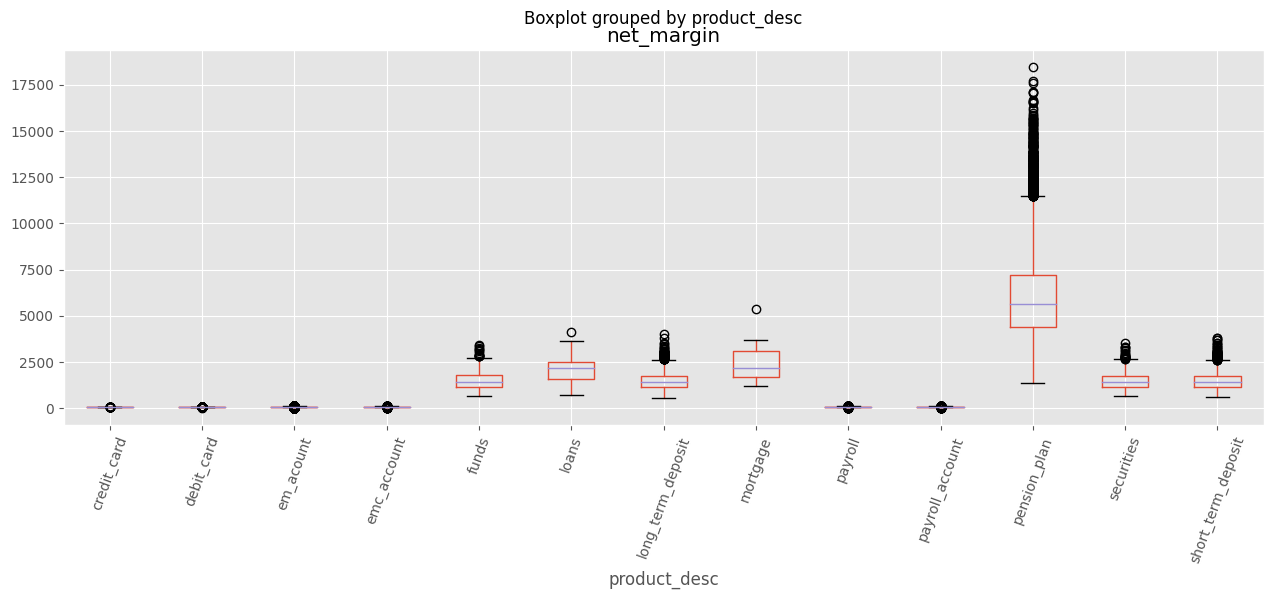

In [70]:
df_sales1.boxplot(column = "net_margin", by = "product_desc", figsize=(15,5))
plt.xticks(rotation=70);

In [76]:
df_sales1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 240773 entries, 0 to 240772
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   sale_ID         240773 non-null  int64         
 1   customer_ID     240773 non-null  object        
 2   month_sale      240773 non-null  datetime64[ns]
 3   product_ID      240773 non-null  object        
 4   net_margin      240773 non-null  float64       
 5   product_desc    240773 non-null  object        
 6   family_product  240773 non-null  object        
 7   month_sales     240773 non-null  int64         
 8   year_sales      240773 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(4)
memory usage: 18.4+ MB


In [77]:
df_sales1['date_adj']=df_sales1['month_sale']-pd.DateOffset(months=1)


In [78]:
df_sales1.head()

,sale_ID,customer_ID,month_sale,product_ID,net_margin,product_desc,family_product,month_sales,year_sales,date_adj
0,6666,33620,2018-05-01,2335,952.9,short_term_deposit,investment,5,2018,2018-04-01
1,6667,35063,2018-06-01,2335,1625.2,short_term_deposit,investment,6,2018,2018-05-01
2,6668,37299,2018-02-01,2335,1279.7,short_term_deposit,investment,2,2018,2018-01-01
3,6669,39997,2018-02-01,2335,1511.9,short_term_deposit,investment,2,2018,2018-01-01
4,6670,44012,2018-02-01,2335,1680.3,short_term_deposit,investment,2,2018,2018-01-01


## Procesamiento de Customers

In [ ]:
# Merge de las tablas relacionadas con el cliente
#df_raw = customer_commercial_activity_raw.merge(customer_sociodemographics_raw, on=["pk_cid","pk_partition"])\
            #.merge(customer_products_raw, on=["pk_cid","pk_partition"])

In [79]:
#Merge de customer_commercial_activity y customer_sociodemografics, customer_products lo dejamos para más tarde

df1_raw=customer_commercial_activity_raw.merge(customer_sociodemographics_raw, on=["pk_cid","pk_partition"])

In [80]:
customer_commercial_activity_raw.shape

(5962924, 7)

In [81]:
customer_sociodemographics_raw.shape

(5962924, 9)

In [82]:
customer_products_raw.shape

(5962924, 18)

In [83]:
df1_raw.shape

(5962924, 14)

In [85]:
df1_raw.head()

,Unnamed: 0_x,pk_cid,pk_partition,entry_date,entry_channel,active_customer,segment,Unnamed: 0_y,country_id,region_code,gender,age,deceased,salary
0,0,1375586,2018-01,2018-01,KHL,1.0,02 - PARTICULARES,0,ES,29.0,H,35,N,87218.10
1,1,1050611,2018-01,2015-08,KHE,0.0,03 - UNIVERSITARIO,1,ES,13.0,V,23,N,35548.74
2,2,1050612,2018-01,2015-08,KHE,0.0,03 - UNIVERSITARIO,2,ES,13.0,V,23,N,122179.11
3,3,1050613,2018-01,2015-08,KHD,0.0,03 - UNIVERSITARIO,3,ES,50.0,H,22,N,119775.54
4,4,1050614,2018-01,2015-08,KHE,1.0,03 - UNIVERSITARIO,4,ES,50.0,V,23,N,NaN


In [86]:
# Análisis inicial de df_sales_raw y aplicamos las acciones propuestas en el análisis de los datasets

df1_raw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5962924 entries, 0 to 5962923
Data columns (total 14 columns):
 #   Column           Dtype  
---  ------           -----  
 0   Unnamed: 0_x     int64  
 1   pk_cid           int64  
 2   pk_partition     object 
 3   entry_date       object 
 4   entry_channel    object 
 5   active_customer  float64
 6   segment          object 
 7   Unnamed: 0_y     int64  
 8   country_id       object 
 9   region_code      float64
 10  gender           object 
 11  age              int64  
 12  deceased         object 
 13  salary           float64
dtypes: float64(3), int64(4), object(7)
memory usage: 682.4+ MB


In [ ]:
# Cogemos una muestra aleatoria del 10% de la base de datos

# n = int(len(df_raw) * 0.1)
# df1 = df_raw.sample(n)

In [87]:
df1 = df1_raw.copy()

In [ ]:
df1.shape

In [89]:
#  Eliminamos las columnas "Unnamed"
df1.drop("Unnamed: 0_x", axis = 1, inplace = True)
df1.drop("Unnamed: 0_y", axis = 1, inplace = True)


In [91]:
# Renombrar columnas para alinear el naming, por ejemplo variable cid como "client_ID", pk_sale como "sale_ID"
df1.rename({"pk_cid": "customer_ID","pk_partition": "partition_ID", 'country_id':'country_ID'},axis='columns',inplace = True)

In [92]:
df1.head()

,customer_ID,partition_ID,entry_date,entry_channel,active_customer,segment,country_ID,region_code,gender,age,deceased,salary
0,1375586,2018-01,2018-01,KHL,1.0,02 - PARTICULARES,ES,29.0,H,35,N,87218.10
1,1050611,2018-01,2015-08,KHE,0.0,03 - UNIVERSITARIO,ES,13.0,V,23,N,35548.74
2,1050612,2018-01,2015-08,KHE,0.0,03 - UNIVERSITARIO,ES,13.0,V,23,N,122179.11
3,1050613,2018-01,2015-08,KHD,0.0,03 - UNIVERSITARIO,ES,50.0,H,22,N,119775.54
4,1050614,2018-01,2015-08,KHE,1.0,03 - UNIVERSITARIO,ES,50.0,V,23,N,NaN


### Atributos de baja varianza

In [93]:
df1["country_ID"].value_counts(normalize=True)*100

ES    99.962233
GB     0.007396
FR     0.003773
DE     0.003337
US     0.003270
CH     0.003253
BR     0.001459
BE     0.001358
VE     0.001325
IE     0.001140
MX     0.000973
AT     0.000855
AR     0.000855
PL     0.000822
IT     0.000755
MA     0.000570
CL     0.000503
CN     0.000470
CA     0.000369
LU     0.000285
ET     0.000285
QA     0.000285
CI     0.000285
SA     0.000285
CM     0.000285
SN     0.000285
MR     0.000285
NO     0.000285
RU     0.000285
CO     0.000285
GA     0.000285
GT     0.000285
DO     0.000285
SE     0.000268
DJ     0.000184
PT     0.000184
JM     0.000184
RO     0.000151
HU     0.000134
DZ     0.000117
PE     0.000067
Name: country_ID, dtype: float64

In [94]:
#agrupamos country_id en ES y OTHERS
df1['country_ID'] = df1['country_ID'].apply(lambda x: 'ES' if x == 'ES' else 'OTHERS')

In [95]:
df1["country_ID"].value_counts(normalize=True)*100

ES        99.962233
OTHERS     0.037767
Name: country_ID, dtype: float64

### Gestión de nulos

In [96]:
df1.isnull().sum()

customer_ID              0
partition_ID             0
entry_date               0
entry_channel       133033
active_customer          0
segment             133944
country_ID               0
region_code           2264
gender                  25
age                      0
deceased                 0
salary             1541104
dtype: int64

In [101]:
df1['salary'].sort_values(ascending = False)

3723329    28894395.51
5333283    28894395.51
2446137    28894395.51
3160427    28894395.51
3198603    28894395.51
              ...     
5962906            NaN
5962908            NaN
5962913            NaN
5962921            NaN
5962923            NaN
Name: salary, Length: 5962924, dtype: float64

In [102]:
# Asignamos valor extremos a "salary", "gender", "region_code" ya que vamos a hacer un DecisionTree

print(df1["salary"].describe())
df1["salary"].fillna(value = 0, inplace = True)

print(df1["gender"].value_counts(normalize = True))
df1["gender"].fillna(value = 2, inplace = True)

print(df1["region_code"].describe())
df1["region_code"].fillna(value = 1000, inplace = True)

count    4.421820e+06
mean     1.155833e+05
std      2.000066e+05
min      1.202730e+03
25%      6.141532e+04
50%      8.844147e+04
75%      1.313092e+05
max      2.889440e+07
Name: salary, dtype: float64
H    0.517785
V    0.482215
Name: gender, dtype: float64
count    5.960660e+06
mean     2.581440e+01
std      1.359566e+01
min      1.000000e+00
25%      1.300000e+01
50%      2.800000e+01
75%      3.600000e+01
max      5.200000e+01
Name: region_code, dtype: float64


#### Segment ELIMINAR ( prueba Ricard

In [ ]:
#df_segment = df1.copy()

In [ ]:
#df_segment

In [ ]:
#df_segment[df_segment["segment"].isnull()]

In [ ]:
#df_segment[df_segment["customer_ID"] == 1115187]

In [ ]:
#df1_sorted = df_segment.sort_values(["customer_ID","partition_ID"])

In [ ]:
#df1_sorted

In [ ]:
#cols = ["segment"]
#df1_sorted.loc[:,cols] = df1_sorted.loc[:,cols].bfill()

In [ ]:
#df1[df1["segment"].isnull()]

NICO

In [ ]:
#df1_nico = df1.copy()

In [ ]:
#df1_nico = df1_nico.groupby("partition_ID")["segment","customer_ID","partition_ID"].transform(lambda series: series.backfill().ffill())

In [ ]:
#df1_nico[df1_nico["customer_ID"] == 1550864 ]

In [ ]:
#df1_nico[df1_nico["customer_ID"] == 1416109	 ]

#### Segment (sustituir por valores exisitnetes en otras particiones)

In [103]:
# Array con los ids que tienen nulos en "segment"
ids_nullsegment_unique=df1[(df1['segment'].isnull()==True)]['customer_ID'].unique()

In [104]:
# Dataframe donde revisamos si en la última carga de datos hay un valor para los ids que tienen "segment" nulo. 
valores_nulos_segment=df1[(df1.customer_ID.isin(ids_nullsegment_unique))&(df1['segment'].notnull())&(df1['partition_ID']== "2019-05")][['customer_ID','segment']]

In [105]:
# Si el id con "segment" nulo tenía un valor correcto en la última partition, se lo asignaremos a los valores nulos.
dict_nulos_segment=dict(zip(valores_nulos_segment['customer_ID'],valores_nulos_segment['segment']))

#### Entry_Chanel (sustituir por valores exisitnetes en otras particiones)

In [106]:
# Array con los ids que tienen nulos en "entry_channel"
ids_nullentrychannel_unique=df1[(df1['entry_channel'].isnull()==True)]['customer_ID'].unique()

In [107]:
len(ids_nullentrychannel_unique)

132201

In [108]:
# Dataframe donde revisamos si en la última carga de datos hay un valor para los ids que tienen "entry_channel" nulo. 
valores_nulos_entrychannel=df1[(df1.customer_ID.isin(ids_nullentrychannel_unique))&(df1['entry_channel'].notnull())&(df1['partition_ID']=='2019-05')][['customer_ID','entry_channel']]

In [109]:
# Si el id con "entry_channel" nulo tenía un valor correcto en la última partition, se lo asignaremos a los valores nulos.
dict_nulos_entrychannel=dict(zip(valores_nulos_entrychannel['customer_ID'],valores_nulos_entrychannel['entry_channel']))

In [110]:
df1.set_index('customer_ID',inplace = True)

In [111]:
# Imputamos los últimos valores registrados correctamente en "segment" y "entry_channel"
df1['segment'].fillna(dict_nulos_segment,inplace=True)
df1['entry_channel'].fillna(dict_nulos_entrychannel,inplace=True)

In [112]:
df1.isnull().sum()

partition_ID           0
entry_date             0
entry_channel      13256
active_customer        0
segment            13375
country_ID             0
region_code            0
gender                 0
age                    0
deceased               0
salary                 0
dtype: int64

In [113]:
# Imputación de valores extremos a los nulos que no se han podido deducir por el histórico
df1['segment'].fillna(value='04 - NO SEGMENT',inplace=True)
df1['entry_channel'].fillna(value='ZZZ',inplace=True)

In [114]:
df1['entry_channel'].value_counts()

KHE    3113987
KFC     891403
KHQ     664982
KAT     416503
KHK     231148
KHM     203403
KHN     121440
KFA      79329
KHD      75909
RED      62168
KHL      41768
KHF      20662
ZZZ      13256
KHO       9295
KAZ       5635
KHC       5241
KBG       1662
KHP        775
KEH        728
007        617
013        397
KAG        335
KAS        305
KBZ        198
KAA        193
KAR        157
KAY        149
KAF        123
KAB         95
KFD         91
KCC         89
KAW         65
KAQ         52
KDH         51
KCH         48
KAE         48
KCB         47
KAD         45
KAM         43
KAH         40
KAK         34
KAJ         33
KDT         23
KFF         22
KBO         21
KEY         20
KCI         17
KBH         17
KGN         17
KGX         17
KFS         17
KCL         17
KBE         17
KFK         17
KGC         17
004         17
KDR         16
KFL         13
KBW         12
KCK         11
KES         11
KBU         11
KAI         11
KBY         11
KHS         10
KEJ          8
KDA       

In [115]:
def setOthers(dataframe, column, num_values=5):
    top_categories = dataframe[column].value_counts().head(num_values)
    top_categories_list = top_categories.index.to_list()
    top_categories_list.append('OTHERS')
    dataframe[column] = pd.Categorical(dataframe[column], categories=top_categories_list)
    return dataframe[column].fillna('OTHERS')

In [116]:
df1['entry_channel']=setOthers(df1,'entry_channel',num_values=13)

In [117]:
df1['entry_channel'].value_counts()

KHE       3113987
KFC        891403
KHQ        664982
KAT        416503
KHK        231148
KHM        203403
KHN        121440
KFA         79329
KHD         75909
RED         62168
KHL         41768
OTHERS      26966
KHF         20662
ZZZ         13256
Name: entry_channel, dtype: int64

In [118]:
df1.isnull().sum()

partition_ID       0
entry_date         0
entry_channel      0
active_customer    0
segment            0
country_ID         0
region_code        0
gender             0
age                0
deceased           0
salary             0
dtype: int64

In [ ]:
df1.head()

In [119]:
df1=df1.reset_index()

In [120]:
df1.head()

,customer_ID,partition_ID,entry_date,entry_channel,active_customer,segment,country_ID,region_code,gender,age,deceased,salary
0,1375586,2018-01,2018-01,KHL,1.0,02 - PARTICULARES,ES,29.0,H,35,N,87218.10
1,1050611,2018-01,2015-08,KHE,0.0,03 - UNIVERSITARIO,ES,13.0,V,23,N,35548.74
2,1050612,2018-01,2015-08,KHE,0.0,03 - UNIVERSITARIO,ES,13.0,V,23,N,122179.11
3,1050613,2018-01,2015-08,KHD,0.0,03 - UNIVERSITARIO,ES,50.0,H,22,N,119775.54
4,1050614,2018-01,2015-08,KHE,1.0,03 - UNIVERSITARIO,ES,50.0,V,23,N,0.00


## Preprocesamiento de Customer Products

In [121]:
customer_products_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5962924 entries, 0 to 5962923
Data columns (total 18 columns):
 #   Column              Dtype  
---  ------              -----  
 0   Unnamed: 0          int64  
 1   pk_cid              int64  
 2   pk_partition        object 
 3   short_term_deposit  int64  
 4   loans               int64  
 5   mortgage            int64  
 6   funds               int64  
 7   securities          int64  
 8   long_term_deposit   int64  
 9   em_account_pp       int64  
 10  credit_card         int64  
 11  payroll             float64
 12  pension_plan        float64
 13  payroll_account     int64  
 14  emc_account         int64  
 15  debit_card          int64  
 16  em_account_p        int64  
 17  em_acount           int64  
dtypes: float64(2), int64(15), object(1)
memory usage: 818.9+ MB


In [122]:
df_customer_products= customer_products_raw.copy()

In [123]:
df_customer_products.head()

,Unnamed: 0,pk_cid,pk_partition,short_term_deposit,loans,mortgage,funds,securities,long_term_deposit,em_account_pp,credit_card,payroll,pension_plan,payroll_account,emc_account,debit_card,em_account_p,em_acount
0,0,1375586,2018-01,0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,1
1,1,1050611,2018-01,0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,1
2,2,1050612,2018-01,0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,1
3,3,1050613,2018-01,1,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0
4,4,1050614,2018-01,0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,1


In [124]:
df_customer_products.drop("Unnamed: 0", axis = 1, inplace = True)

In [125]:
# Renombrar columnas para alinear el naming, por ejemplo variable cid como "client_ID", pk_sale como "sale_ID"
df_customer_products.rename({"pk_cid": "customer_ID","pk_partition": "partition_ID"},axis='columns',inplace = True)

In [126]:
df_customer_products["em_account_p"].value_counts(normalize = True)*100

0    99.99943
1     0.00057
Name: em_account_p, dtype: float64

In [127]:
df_customer_products["em_account_pp"].value_counts(normalize = True)*100

0    100.0
Name: em_account_pp, dtype: float64

In [128]:
# Eliminamos variables de baja varianza
del df_customer_products['em_account_pp']
del df_customer_products['em_account_p']


In [129]:
# Eliminamos valores nulos de "payroll" y "pension_plan"

df_customer_products.dropna(subset = ['pension_plan'], inplace = True)

In [130]:
df_customer_products.isnull().sum()

customer_ID           0
partition_ID          0
short_term_deposit    0
loans                 0
mortgage              0
funds                 0
securities            0
long_term_deposit     0
credit_card           0
payroll               0
pension_plan          0
payroll_account       0
emc_account           0
debit_card            0
em_acount             0
dtype: int64

In [132]:
df_customer_products.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5962863 entries, 0 to 5962923
Columns: 15 entries, customer_ID to em_acount
dtypes: float64(2), int64(12), object(1)
memory usage: 727.9+ MB


In [133]:
df_customer_products.reset_index(inplace=True)

In [134]:
df_customer_products.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5962863 entries, 0 to 5962862
Columns: 16 entries, index to em_acount
dtypes: float64(2), int64(13), object(1)
memory usage: 727.9+ MB


### Transformación de fechas

In [135]:
df1.head()

,customer_ID,partition_ID,entry_date,entry_channel,active_customer,segment,country_ID,region_code,gender,age,deceased,salary
0,1375586,2018-01,2018-01,KHL,1.0,02 - PARTICULARES,ES,29.0,H,35,N,87218.10
1,1050611,2018-01,2015-08,KHE,0.0,03 - UNIVERSITARIO,ES,13.0,V,23,N,35548.74
2,1050612,2018-01,2015-08,KHE,0.0,03 - UNIVERSITARIO,ES,13.0,V,23,N,122179.11
3,1050613,2018-01,2015-08,KHD,0.0,03 - UNIVERSITARIO,ES,50.0,H,22,N,119775.54
4,1050614,2018-01,2015-08,KHE,1.0,03 - UNIVERSITARIO,ES,50.0,V,23,N,0.00


In [136]:
# Extraemos año, mes y trimestre de partition ID
df1['partition_date'] = pd.to_datetime(df1['partition_ID'])

df1['partition_year'] = df1['partition_date'].dt.year
df1['partition_month'] = df1['partition_date'].dt.month
df1['partition_quarter'] = df1['partition_date'].dt.quarter

In [137]:
# Transformamos "entry_date" a fecha y extraemos año, mes y trimestre
df1['entry_date']=pd.to_datetime(df1['entry_date'])

df1['entry_year'] = df1['entry_date'].dt.year
df1['entry_month'] = df1['entry_date'].dt.month
df1['entry_quarter'] = df1['entry_date'].dt.quarter

In [138]:
df1.head()

,customer_ID,partition_ID,entry_date,entry_channel,active_customer,segment,country_ID,region_code,gender,age,deceased,salary,partition_date,partition_year,partition_month,partition_quarter,entry_year,entry_month,entry_quarter
0,1375586,2018-01,2018-01-01,KHL,1.0,02 - PARTICULARES,ES,29.0,H,35,N,87218.10,2018-01-01,2018,1,1,2018,1,1
1,1050611,2018-01,2015-08-01,KHE,0.0,03 - UNIVERSITARIO,ES,13.0,V,23,N,35548.74,2018-01-01,2018,1,1,2015,8,3
2,1050612,2018-01,2015-08-01,KHE,0.0,03 - UNIVERSITARIO,ES,13.0,V,23,N,122179.11,2018-01-01,2018,1,1,2015,8,3
3,1050613,2018-01,2015-08-01,KHD,0.0,03 - UNIVERSITARIO,ES,50.0,H,22,N,119775.54,2018-01-01,2018,1,1,2015,8,3
4,1050614,2018-01,2015-08-01,KHE,1.0,03 - UNIVERSITARIO,ES,50.0,V,23,N,0.00,2018-01-01,2018,1,1,2015,8,3


In [139]:

# Extraemos año, mes y trimestre de partition ID
df_customer_products['partition_date'] = pd.to_datetime(df_customer_products['partition_ID'])

df_customer_products['partition_year'] = df_customer_products['partition_date'].dt.year
df_customer_products['partition_month'] = df_customer_products['partition_date'].dt.month
df_customer_products['partition_quarter'] = df_customer_products['partition_date'].dt.quarter

In [140]:
df_customer_products.head()

,index,customer_ID,partition_ID,short_term_deposit,loans,mortgage,funds,securities,long_term_deposit,credit_card,payroll,pension_plan,payroll_account,emc_account,debit_card,em_acount,partition_date,partition_year,partition_month,partition_quarter
0,0,1375586,2018-01,0,0,0,0,0,0,0,0.0,0.0,0,0,0,1,2018-01-01,2018,1,1
1,1,1050611,2018-01,0,0,0,0,0,0,0,0.0,0.0,0,0,0,1,2018-01-01,2018,1,1
2,2,1050612,2018-01,0,0,0,0,0,0,0,0.0,0.0,0,0,0,1,2018-01-01,2018,1,1
3,3,1050613,2018-01,1,0,0,0,0,0,0,0.0,0.0,0,0,0,0,2018-01-01,2018,1,1
4,4,1050614,2018-01,0,0,0,0,0,0,0,0.0,0.0,0,0,0,1,2018-01-01,2018,1,1


### Tranformación de numéricas

In [141]:
# Cambiamos el type de las variables con float a int (active_customer, payroll y pension_plan), excepto salary, que si que es float

variables_to_int_customer_products = [ 'payroll', 'pension_plan']
variables_to_int_df1 = ['active_customer']

df_customer_products[variables_to_int_customer_products] = df_customer_products[variables_to_int_customer_products].applymap(int)
df1[variables_to_int_df1] = df1[variables_to_int_df1].applymap(int)

In [ ]:
df_sales2=df_sales1.to_pickle('/content/drive/MyDrive/TFM  Data Science/df_sales2')


In [144]:
#df_sales2=pd.read_pickle('/content/drive/MyDrive/TFM  Data Science/df_sales2') #Drive de Eva
df_sales2=pd.read_pickle('/content/drive/MyDrive/Master_DS/TFM_Data_Science/df_sales2') #Drive de Culebra

## Merge tabla sales y resto del dataset

In [145]:
df_sales2.head()

,sale_ID,customer_ID,month_sale,product_ID,net_margin,product_desc,family_product,month_sales,year_sales,date_adj
0,6666,33620,2018-05-01,2335,952.9,short_term_deposit,investment,5,2018,2018-04-01
1,6667,35063,2018-06-01,2335,1625.2,short_term_deposit,investment,6,2018,2018-05-01
2,6668,37299,2018-02-01,2335,1279.7,short_term_deposit,investment,2,2018,2018-01-01
3,6669,39997,2018-02-01,2335,1511.9,short_term_deposit,investment,2,2018,2018-01-01
4,6670,44012,2018-02-01,2335,1680.3,short_term_deposit,investment,2,2018,2018-01-01


In [146]:
df_sales2=df_sales2.rename(columns={'date_adj':'partition_date'})

In [147]:
df_sales2.head()

,sale_ID,customer_ID,month_sale,product_ID,net_margin,product_desc,family_product,month_sales,year_sales,partition_date
0,6666,33620,2018-05-01,2335,952.9,short_term_deposit,investment,5,2018,2018-04-01
1,6667,35063,2018-06-01,2335,1625.2,short_term_deposit,investment,6,2018,2018-05-01
2,6668,37299,2018-02-01,2335,1279.7,short_term_deposit,investment,2,2018,2018-01-01
3,6669,39997,2018-02-01,2335,1511.9,short_term_deposit,investment,2,2018,2018-01-01
4,6670,44012,2018-02-01,2335,1680.3,short_term_deposit,investment,2,2018,2018-01-01


In [148]:
df_sales2.shape

(240773, 10)

In [149]:
df_sales2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 240773 entries, 0 to 240772
Data columns (total 10 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   sale_ID         240773 non-null  int64         
 1   customer_ID     240773 non-null  object        
 2   month_sale      240773 non-null  datetime64[ns]
 3   product_ID      240773 non-null  object        
 4   net_margin      240773 non-null  float64       
 5   product_desc    240773 non-null  object        
 6   family_product  240773 non-null  object        
 7   month_sales     240773 non-null  int64         
 8   year_sales      240773 non-null  int64         
 9   partition_date  240773 non-null  datetime64[ns]
dtypes: datetime64[ns](2), float64(1), int64(3), object(4)
memory usage: 20.2+ MB


In [150]:
df_sales2['customer_ID']=df_sales2['customer_ID'].astype('int')

In [151]:
df_sales2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 240773 entries, 0 to 240772
Data columns (total 10 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   sale_ID         240773 non-null  int64         
 1   customer_ID     240773 non-null  int64         
 2   month_sale      240773 non-null  datetime64[ns]
 3   product_ID      240773 non-null  object        
 4   net_margin      240773 non-null  float64       
 5   product_desc    240773 non-null  object        
 6   family_product  240773 non-null  object        
 7   month_sales     240773 non-null  int64         
 8   year_sales      240773 non-null  int64         
 9   partition_date  240773 non-null  datetime64[ns]
dtypes: datetime64[ns](2), float64(1), int64(4), object(3)
memory usage: 20.2+ MB


In [152]:
df1.head()

,customer_ID,partition_ID,entry_date,entry_channel,active_customer,segment,country_ID,region_code,gender,age,deceased,salary,partition_date,partition_year,partition_month,partition_quarter,entry_year,entry_month,entry_quarter
0,1375586,2018-01,2018-01-01,KHL,1,02 - PARTICULARES,ES,29.0,H,35,N,87218.10,2018-01-01,2018,1,1,2018,1,1
1,1050611,2018-01,2015-08-01,KHE,0,03 - UNIVERSITARIO,ES,13.0,V,23,N,35548.74,2018-01-01,2018,1,1,2015,8,3
2,1050612,2018-01,2015-08-01,KHE,0,03 - UNIVERSITARIO,ES,13.0,V,23,N,122179.11,2018-01-01,2018,1,1,2015,8,3
3,1050613,2018-01,2015-08-01,KHD,0,03 - UNIVERSITARIO,ES,50.0,H,22,N,119775.54,2018-01-01,2018,1,1,2015,8,3
4,1050614,2018-01,2015-08-01,KHE,1,03 - UNIVERSITARIO,ES,50.0,V,23,N,0.00,2018-01-01,2018,1,1,2015,8,3


In [153]:
df_total1 = df_sales2.merge(df1, right_on = ['customer_ID', 'partition_date'], left_on= ['customer_ID',"month_sale"], how = "left")


In [154]:
df_total1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 240773 entries, 0 to 240772
Data columns (total 28 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   sale_ID            240773 non-null  int64         
 1   customer_ID        240773 non-null  int64         
 2   month_sale         240773 non-null  datetime64[ns]
 3   product_ID         240773 non-null  object        
 4   net_margin         240773 non-null  float64       
 5   product_desc       240773 non-null  object        
 6   family_product     240773 non-null  object        
 7   month_sales        240773 non-null  int64         
 8   year_sales         240773 non-null  int64         
 9   partition_date_x   240773 non-null  datetime64[ns]
 10  partition_ID       240773 non-null  object        
 11  entry_date         240773 non-null  datetime64[ns]
 12  entry_channel      240773 non-null  category      
 13  active_customer    240773 non-null  int64   

In [155]:
df_total1.head()

,sale_ID,customer_ID,month_sale,product_ID,net_margin,product_desc,family_product,month_sales,year_sales,partition_date_x,...,age,deceased,salary,partition_date_y,partition_year,partition_month,partition_quarter,entry_year,entry_month,entry_quarter
0,6666,33620,2018-05-01,2335,952.9,short_term_deposit,investment,5,2018,2018-04-01,...,50,N,138618.57,2018-05-01,2018,5,2,2018,4,2
1,6667,35063,2018-06-01,2335,1625.2,short_term_deposit,investment,6,2018,2018-05-01,...,62,N,125530.41,2018-06-01,2018,6,2,2018,4,2
2,6668,37299,2018-02-01,2335,1279.7,short_term_deposit,investment,2,2018,2018-01-01,...,54,N,0.00,2018-02-01,2018,2,1,2018,1,1
3,6669,39997,2018-02-01,2335,1511.9,short_term_deposit,investment,2,2018,2018-01-01,...,62,N,201575.01,2018-02-01,2018,2,1,2018,1,1
4,6670,44012,2018-02-01,2335,1680.3,short_term_deposit,investment,2,2018,2018-01-01,...,42,N,97601.04,2018-02-01,2018,2,1,2018,1,1


In [156]:
df_total1.rename({"partition_date_x": "date_adj"},axis='columns',inplace = True)


In [157]:
del(df_total1['partition_date_y'])

In [158]:
del(df_total1['partition_month'])
del(df_total1['partition_year'])
del(df_total1['partition_quarter'])

In [159]:
df_total1.head()

,sale_ID,customer_ID,month_sale,product_ID,net_margin,product_desc,family_product,month_sales,year_sales,date_adj,...,segment,country_ID,region_code,gender,age,deceased,salary,entry_year,entry_month,entry_quarter
0,6666,33620,2018-05-01,2335,952.9,short_term_deposit,investment,5,2018,2018-04-01,...,02 - PARTICULARES,ES,28.0,H,50,N,138618.57,2018,4,2
1,6667,35063,2018-06-01,2335,1625.2,short_term_deposit,investment,6,2018,2018-05-01,...,01 - TOP,ES,28.0,H,62,N,125530.41,2018,4,2
2,6668,37299,2018-02-01,2335,1279.7,short_term_deposit,investment,2,2018,2018-01-01,...,01 - TOP,ES,30.0,V,54,N,0.00,2018,1,1
3,6669,39997,2018-02-01,2335,1511.9,short_term_deposit,investment,2,2018,2018-01-01,...,02 - PARTICULARES,ES,41.0,V,62,N,201575.01,2018,1,1
4,6670,44012,2018-02-01,2335,1680.3,short_term_deposit,investment,2,2018,2018-01-01,...,02 - PARTICULARES,ES,28.0,V,42,N,97601.04,2018,1,1


In [160]:
df_customer_products.head()

,index,customer_ID,partition_ID,short_term_deposit,loans,mortgage,funds,securities,long_term_deposit,credit_card,payroll,pension_plan,payroll_account,emc_account,debit_card,em_acount,partition_date,partition_year,partition_month,partition_quarter
0,0,1375586,2018-01,0,0,0,0,0,0,0,0,0,0,0,0,1,2018-01-01,2018,1,1
1,1,1050611,2018-01,0,0,0,0,0,0,0,0,0,0,0,0,1,2018-01-01,2018,1,1
2,2,1050612,2018-01,0,0,0,0,0,0,0,0,0,0,0,0,1,2018-01-01,2018,1,1
3,3,1050613,2018-01,1,0,0,0,0,0,0,0,0,0,0,0,0,2018-01-01,2018,1,1
4,4,1050614,2018-01,0,0,0,0,0,0,0,0,0,0,0,0,1,2018-01-01,2018,1,1


In [161]:
df_customer_products.shape

(5962863, 20)

In [162]:
df_total1.head()
    


,sale_ID,customer_ID,month_sale,product_ID,net_margin,product_desc,family_product,month_sales,year_sales,date_adj,...,segment,country_ID,region_code,gender,age,deceased,salary,entry_year,entry_month,entry_quarter
0,6666,33620,2018-05-01,2335,952.9,short_term_deposit,investment,5,2018,2018-04-01,...,02 - PARTICULARES,ES,28.0,H,50,N,138618.57,2018,4,2
1,6667,35063,2018-06-01,2335,1625.2,short_term_deposit,investment,6,2018,2018-05-01,...,01 - TOP,ES,28.0,H,62,N,125530.41,2018,4,2
2,6668,37299,2018-02-01,2335,1279.7,short_term_deposit,investment,2,2018,2018-01-01,...,01 - TOP,ES,30.0,V,54,N,0.00,2018,1,1
3,6669,39997,2018-02-01,2335,1511.9,short_term_deposit,investment,2,2018,2018-01-01,...,02 - PARTICULARES,ES,41.0,V,62,N,201575.01,2018,1,1
4,6670,44012,2018-02-01,2335,1680.3,short_term_deposit,investment,2,2018,2018-01-01,...,02 - PARTICULARES,ES,28.0,V,42,N,97601.04,2018,1,1


In [163]:
df_total1.shape

(240773, 24)

In [164]:
df_total2=df_total1.merge(df_customer_products,  left_on= ['customer_ID',"date_adj"],right_on = ['customer_ID', 'partition_date'], how = "left")


In [165]:
df_total2.shape

(240773, 43)

In [166]:
df_total2.head()

,sale_ID,customer_ID,month_sale,product_ID,net_margin,product_desc,family_product,month_sales,year_sales,date_adj,...,payroll,pension_plan,payroll_account,emc_account,debit_card,em_acount,partition_date,partition_year,partition_month,partition_quarter
0,6666,33620,2018-05-01,2335,952.9,short_term_deposit,investment,5,2018,2018-04-01,...,0.0,0.0,0.0,0.0,0.0,1.0,2018-04-01,2018.0,4.0,2.0
1,6667,35063,2018-06-01,2335,1625.2,short_term_deposit,investment,6,2018,2018-05-01,...,0.0,0.0,0.0,0.0,0.0,1.0,2018-05-01,2018.0,5.0,2.0
2,6668,37299,2018-02-01,2335,1279.7,short_term_deposit,investment,2,2018,2018-01-01,...,0.0,0.0,0.0,0.0,0.0,1.0,2018-01-01,2018.0,1.0,1.0
3,6669,39997,2018-02-01,2335,1511.9,short_term_deposit,investment,2,2018,2018-01-01,...,0.0,0.0,0.0,0.0,0.0,1.0,2018-01-01,2018.0,1.0,1.0
4,6670,44012,2018-02-01,2335,1680.3,short_term_deposit,investment,2,2018,2018-01-01,...,0.0,0.0,0.0,0.0,0.0,1.0,2018-01-01,2018.0,1.0,1.0


In [167]:
df_total2.head().T

,0,1,2,3,4
sale_ID,6666,6667,6668,6669,6670
customer_ID,33620,35063,37299,39997,44012
month_sale,2018-05-01 00:00:00,2018-06-01 00:00:00,2018-02-01 00:00:00,2018-02-01 00:00:00,2018-02-01 00:00:00
product_ID,2335,2335,2335,2335,2335
net_margin,952.9,1625.2,1279.7,1511.9,1680.3
product_desc,short_term_deposit,short_term_deposit,short_term_deposit,short_term_deposit,short_term_deposit
family_product,investment,investment,investment,investment,investment
month_sales,5,6,2,2,2
year_sales,2018,2018,2018,2018,2018
date_adj,2018-04-01 00:00:00,2018-05-01 00:00:00,2018-01-01 00:00:00,2018-01-01 00:00:00,2018-01-01 00:00:00


In [168]:
df_total2.isnull().sum()
# Los nulos que encontramos son nuevos clientes, que para la tabla cruzada con month-1, en el mes anterior no tenían datos

sale_ID                   0
customer_ID               0
month_sale                0
product_ID                0
net_margin                0
product_desc              0
family_product            0
month_sales               0
year_sales                0
date_adj                  0
partition_ID_x            0
entry_date                0
entry_channel             0
active_customer           0
segment                   0
country_ID                0
region_code               0
gender                    0
age                       0
deceased                  0
salary                    0
entry_year                0
entry_month               0
entry_quarter             0
index                 98469
partition_ID_y        98469
short_term_deposit    98469
loans                 98469
mortgage              98469
funds                 98469
securities            98469
long_term_deposit     98469
credit_card           98469
payroll               98469
pension_plan          98469
payroll_account     

In [169]:
del(df_total2['index'])

In [170]:
del(df_total2['partition_ID_x'])

In [171]:
del(df_total2['partition_ID_y'])

In [ ]:
df_total2.isnull().sum()

In [173]:
df_total2.fillna(value = 0, inplace = True)

In [174]:
df_total2.isnull().sum()

sale_ID               0
customer_ID           0
month_sale            0
product_ID            0
net_margin            0
product_desc          0
family_product        0
month_sales           0
year_sales            0
date_adj              0
entry_date            0
entry_channel         0
active_customer       0
segment               0
country_ID            0
region_code           0
gender                0
age                   0
deceased              0
salary                0
entry_year            0
entry_month           0
entry_quarter         0
short_term_deposit    0
loans                 0
mortgage              0
funds                 0
securities            0
long_term_deposit     0
credit_card           0
payroll               0
pension_plan          0
payroll_account       0
emc_account           0
debit_card            0
em_acount             0
partition_date        0
partition_year        0
partition_month       0
partition_quarter     0
dtype: int64

In [175]:
df_total3=df_total2.to_pickle('/content/drive/MyDrive/Master_DS/TFM_Data_Science/df_total3')


In [187]:
df_total3=pd.read_pickle('/content/drive/MyDrive/Master_DS/TFM_Data_Science/df_total3')

In [188]:
df_total3.head().T

,0,1,2,3,4
sale_ID,6666,6667,6668,6669,6670
customer_ID,33620,35063,37299,39997,44012
month_sale,2018-05-01 00:00:00,2018-06-01 00:00:00,2018-02-01 00:00:00,2018-02-01 00:00:00,2018-02-01 00:00:00
product_ID,2335,2335,2335,2335,2335
net_margin,952.9,1625.2,1279.7,1511.9,1680.3
product_desc,short_term_deposit,short_term_deposit,short_term_deposit,short_term_deposit,short_term_deposit
family_product,investment,investment,investment,investment,investment
month_sales,5,6,2,2,2
year_sales,2018,2018,2018,2018,2018
date_adj,2018-04-01 00:00:00,2018-05-01 00:00:00,2018-01-01 00:00:00,2018-01-01 00:00:00,2018-01-01 00:00:00


## Ordenación de columnas y tratamiento de variables del df mergeado

In [191]:
df_total3.columns.to_list()

['sale_ID',
 'customer_ID',
 'month_sale',
 'product_ID',
 'net_margin',
 'product_desc',
 'family_product',
 'month_sales',
 'year_sales',
 'date_adj',
 'entry_date',
 'entry_channel',
 'active_customer',
 'segment',
 'country_ID',
 'region_code',
 'gender',
 'age',
 'deceased',
 'salary',
 'entry_year',
 'entry_month',
 'entry_quarter',
 'short_term_deposit',
 'loans',
 'mortgage',
 'funds',
 'securities',
 'long_term_deposit',
 'credit_card',
 'payroll',
 'pension_plan',
 'payroll_account',
 'emc_account',
 'debit_card',
 'em_acount',
 'partition_date',
 'partition_year',
 'partition_month',
 'partition_quarter']

In [192]:
# Reordenación del dataset
df_total3 = df_total3.reindex(columns=[
              
              'sale_ID',
              'month_sale',
              'year_sales',
              'month_sales',
              'product_ID',
              'product_desc',
              'family_product',
              'net_margin',
              'date_adj',
              'customer_ID',
              'entry_date',
              'entry_year',
              'entry_month',
              'entry_quarter',
              'entry_channel',
              'active_customer',
              'segment',
              'country_ID',
              'region_code',
              'gender',
              'age',
              'deceased',
              'salary',
              'partition_date',
              'partition_year',
              'partition_month',
              'partition_quarter',
              'short_term_deposit',
              'loans',
              'mortgage',
              'funds',
              'securities',
              'long_term_deposit',
              'credit_card',
              'payroll',
              'pension_plan',
              'payroll_account',
              'emc_account',
              'debit_card',
              'em_acount',
              ])

In [193]:
del df_total3['date_adj']

In [194]:
df_total3.head().T

,0,1,2,3,4
sale_ID,6666,6667,6668,6669,6670
month_sale,2018-05-01 00:00:00,2018-06-01 00:00:00,2018-02-01 00:00:00,2018-02-01 00:00:00,2018-02-01 00:00:00
year_sales,2018,2018,2018,2018,2018
month_sales,5,6,2,2,2
product_ID,2335,2335,2335,2335,2335
product_desc,short_term_deposit,short_term_deposit,short_term_deposit,short_term_deposit,short_term_deposit
family_product,investment,investment,investment,investment,investment
net_margin,952.9,1625.2,1279.7,1511.9,1680.3
customer_ID,33620,35063,37299,39997,44012
entry_date,2018-04-01 00:00:00,2018-04-01 00:00:00,2018-01-01 00:00:00,2018-01-01 00:00:00,2018-01-01 00:00:00


In [195]:
df_total3['age'].value_counts()

20     32380
21     14278
22     10463
23      9420
32      7483
33      7230
28      7220
30      7183
29      7098
24      7064
34      6857
31      6844
35      6352
36      6061
25      5934
37      5576
27      5575
39      5454
26      5371
38      5161
40      4970
41      4728
42      4445
43      3973
44      3641
19      3638
45      3365
46      3162
47      3084
48      2857
49      2784
50      2611
51      2246
52      2203
53      2002
54      1759
55      1589
56      1525
57      1482
58      1375
59      1190
61      1161
60      1114
62       985
63       807
64       747
65       730
66       687
67       642
68       556
69       490
70       460
71       416
73       403
72       390
77       285
75       284
76       283
74       277
81       240
79       190
78       184
80       184
84       179
82       179
83       178
86       176
85       171
87       143
88       107
89       100
90        99
91        68
93        31
94        31
92        29
95        27

In [196]:
df_total3.info()
# sale_ID establecer como índice junto con customer_ID        

# month_sale --> BORRAR
# product_ID --> BORRAR 
# entry_date --> BORRAR 
# partition_date --> BORRAR       

# product_desc --> OHE
# family_product --> OHE
# entry_channel --> OHE         
# segment --> OHE 
# country_id --> OHE
# gender --> OHE
# deceased --> OHE           
# 

# partition_year --> A dtype INT    
# partition_month --> A dtype INT      
# partition_quarter --> A dtype INT         

<class 'pandas.core.frame.DataFrame'>
Int64Index: 240773 entries, 0 to 240772
Data columns (total 39 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   sale_ID             240773 non-null  int64         
 1   month_sale          240773 non-null  datetime64[ns]
 2   year_sales          240773 non-null  int64         
 3   month_sales         240773 non-null  int64         
 4   product_ID          240773 non-null  object        
 5   product_desc        240773 non-null  object        
 6   family_product      240773 non-null  object        
 7   net_margin          240773 non-null  float64       
 8   customer_ID         240773 non-null  int64         
 9   entry_date          240773 non-null  datetime64[ns]
 10  entry_year          240773 non-null  int64         
 11  entry_month         240773 non-null  int64         
 12  entry_quarter       240773 non-null  int64         
 13  entry_channel       240773 no

In [197]:
df_pre = df_total3.copy()

In [198]:
# sale_ID establecer como índice junto con customer_ID   
df_pre.set_index(['sale_ID', 'customer_ID'], inplace=True)

In [199]:
  
# month_sale --> BORRAR
# product_ID --> BORRAR 
# entry_date --> BORRAR 
# partition_date --> BORRAR       

df_pre = df_pre.drop(['month_sale', 'product_ID', 'entry_date', 'partition_date'], axis=1)

    


In [200]:
df_pre.shape

(240773, 33)

In [201]:
# partition_year --> A dtype INT    
# partition_month --> A dtype INT      
# partition_quarter --> A dtype INT

# region_code --> A dtype OBJECT
df_pre[['partition_year', 'partition_month', 'partition_quarter']] = df_pre[['partition_year', 'partition_month', 'partition_quarter']].astype('int')

df_pre['region_code']=df_pre['region_code'].astype(object)

In [202]:
df_pre.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 240773 entries, (6666, 33620) to (247438, 1553571)
Data columns (total 33 columns):
 #   Column              Non-Null Count   Dtype   
---  ------              --------------   -----   
 0   year_sales          240773 non-null  int64   
 1   month_sales         240773 non-null  int64   
 2   product_desc        240773 non-null  object  
 3   family_product      240773 non-null  object  
 4   net_margin          240773 non-null  float64 
 5   entry_year          240773 non-null  int64   
 6   entry_month         240773 non-null  int64   
 7   entry_quarter       240773 non-null  int64   
 8   entry_channel       240773 non-null  category
 9   active_customer     240773 non-null  int64   
 10  segment             240773 non-null  object  
 11  country_ID          240773 non-null  object  
 12  region_code         240773 non-null  object  
 13  gender              240773 non-null  object  
 14  age                 240773 non-null  int64   

### Transformación de categóricas

In [203]:
def OHE(dataframe, column_name):
    _dummy_dataset = pd.get_dummies(dataframe[column_name], prefix=column_name)
    dataframe = pd.concat([dataframe, _dummy_dataset], axis=1)
    return dataframe.drop(column_name, axis=1)

In [204]:
# OHE "entry_channel"

df_pre = OHE(df_pre, "entry_channel")

In [205]:
# OHE segment

df_pre = OHE(df_pre, "segment")

In [206]:
# OHE region code

df_pre = OHE(df_pre, "region_code")

<ipython-input-203-e11062fb3a8e>:2: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  _dummy_dataset = pd.get_dummies(dataframe[column_name], prefix=column_name)


In [207]:
# OHE product_desc
df_pre = OHE(df_pre, "product_desc")

In [208]:
# OHE family_product
df_pre = OHE(df_pre, "family_product")

In [211]:
# OHE country_id 
df_pre = OHE(df_pre, "country_ID")

In [210]:
# gender --> 1 = Hembras, 0 = Varones, 2 = Nulos

df_pre["gender"] = df_pre["gender"].replace("H", 1) # H es de Hembras
df_pre["gender"] = df_pre["gender"].replace("V", 0) # V es de Varones

In [212]:
# deceased --> 1 = Fallecido, 0 = No fallecido

df_pre["deceased"] = df_pre["deceased"].replace("N", 0) # N es no moñeco
df_pre["deceased"] = df_pre["deceased"].replace("S", 1) # S es moñeco

In [213]:
df_pre.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 240773 entries, (6666, 33620) to (247438, 1553571)
Data columns (total 118 columns):
 #    Column                           Dtype  
---   ------                           -----  
 0    year_sales                       int64  
 1    month_sales                      int64  
 2    net_margin                       float64
 3    entry_year                       int64  
 4    entry_month                      int64  
 5    entry_quarter                    int64  
 6    active_customer                  int64  
 7    gender                           int64  
 8    age                              int64  
 9    deceased                         int64  
 10   salary                           float64
 11   partition_year                   int64  
 12   partition_month                  int64  
 13   partition_quarter                int64  
 14   short_term_deposit               float64
 15   loans                            float64
 16   mortgage     

In [214]:
df_final=df_pre.to_pickle('/content/drive/MyDrive/Master_DS/TFM_Data_Science/df_preprocesado')

In [215]:
df_final=pd.read_pickle('/content/drive/MyDrive/Master_DS/TFM_Data_Science/df_preprocesado')

## Ajustamos el data set para el TARGET "pension plan"

In [216]:
del df_final['pension_plan']

In [217]:
del df_final['family_product_pension_plan']

In [218]:
TARGET = 'product_desc_pension_plan'

In [219]:
df_final['product_desc_pension_plan'].value_counts(normalize = True)

0    0.919555
1    0.080445
Name: product_desc_pension_plan, dtype: float64

In [ ]:
# Un 8.04% de las ventas realizadas corresponden a planes de pensiones

In [221]:
# Por curiosidad consultamos este dato para los TARGET1 y TARGET2 propuestos provisionales
df_final['product_desc_debit_card'].value_counts(normalize = True)

0    0.838686
1    0.161314
Name: product_desc_debit_card, dtype: float64

In [222]:
df_final['product_desc_emc_account'].value_counts(normalize = True)

0    0.948819
1    0.051181
Name: product_desc_emc_account, dtype: float64

## Partición train/test/validation

In [223]:
#df = df1.copy()

In [ ]:
#df.drop(["entry_date", "partition_date"],axis = 1,inplace = True)

In [224]:
df_final.shape

(240773, 116)

In [ ]:
# La partición de validación tiene que ser lo más parecida a la realidad posible, un % del dataset siempre mayor de 1000 filas. tenemos 240.773 en total
# Tomaremos para validación el último mes registrado, mayo de 2019, y el resto de datos para train/test. Si vemos que los números descuadran mucho se propone otra división.

In [225]:
# Partición de validación y develop
val_df = df_final[(df_final['year_sales']==2019) & (df_final['month_sales']==5)]
dev_df = df_final[~((df_final['year_sales'] == 2019) & (df_final['month_sales'] == 5))]

In [226]:
val_df.shape # No es un mal número para validar, unos 10k registros

(10211, 116)

In [227]:
dev_df.shape # Buen número para train-test, 230k registros

(230562, 116)

In [228]:
val_df_y = val_df[[TARGET]]

val_df_X = val_df.drop(TARGET,axis=1)

In [229]:
dev_df_y = dev_df[[TARGET]]

dev_df_x = dev_df.drop(TARGET,axis=1)

### Train y Test

In [ ]:
#20% del dataset de development para test

In [230]:
X_train, X_test, y_train, y_test = model_selection.train_test_split( dev_df_x, dev_df_y, test_size=0.2, random_state=42)

In [ ]:
#Comprobar que la distribución de ambas particiones es parecida (media, percentiles y distrribución std). Si no lo es, cambiamos el random state o utilizamos k.fold

In [231]:
X_train.describe().T.head()

,count,mean,std,min,25%,50%,75%,max
year_sales,184449.0,2018.193224,0.394828,2018.0,2018.0,2018.0,2018.0,2019.0
month_sales,184449.0,6.638035,3.427069,1.0,3.0,7.0,10.0,12.0
net_margin,184449.0,601.373881,1724.543255,25.0,61.5,69.2,79.2,18466.4
entry_year,184449.0,2017.535584,1.020136,2015.0,2017.0,2018.0,2018.0,2019.0
entry_month,184449.0,7.234807,3.320241,1.0,4.0,8.0,10.0,12.0


In [232]:
X_test.describe().T.head()

,count,mean,std,min,25%,50%,75%,max
year_sales,46113.0,2018.194891,0.396121,2018.0,2018.0,2018.0,2018.0,2019.0
month_sales,46113.0,6.668271,3.437022,1.0,3.0,7.0,10.0,12.0
net_margin,46113.0,588.346902,1689.876761,30.9,61.5,69.2,79.0,16219.3
entry_year,46113.0,2017.549758,1.010850,2015.0,2017.0,2018.0,2018.0,2019.0
entry_month,46113.0,7.228005,3.320450,1.0,4.0,8.0,10.0,12.0


# 4.- Modelling

## Decission Tree

In [233]:
#Instanciamos el modelo
dt=DecisionTreeClassifier(max_depth=6,random_state=42, min_samples_leaf=500)

In [234]:
#lo entrenamos con el dataset de train
dt.fit(X=X_train,y=y_train)

DecisionTreeClassifier(max_depth=6, min_samples_leaf=500, random_state=42)

In [235]:
#lo pintamos
tree_data=export_graphviz(
    decision_tree=dt,
    out_file=None, 
    max_depth=None,
    feature_names=X_test.columns,
    class_names=['no_pension_plan','pension_plan'],
    label="all",
    filled=True,
    leaves_parallel=False,
    impurity=True,
    node_ids=False,
    proportion=False,
    rotate=True,
    rounded=True,
    special_characters=False,
    precision=3,
    fontname="helvetica",
)

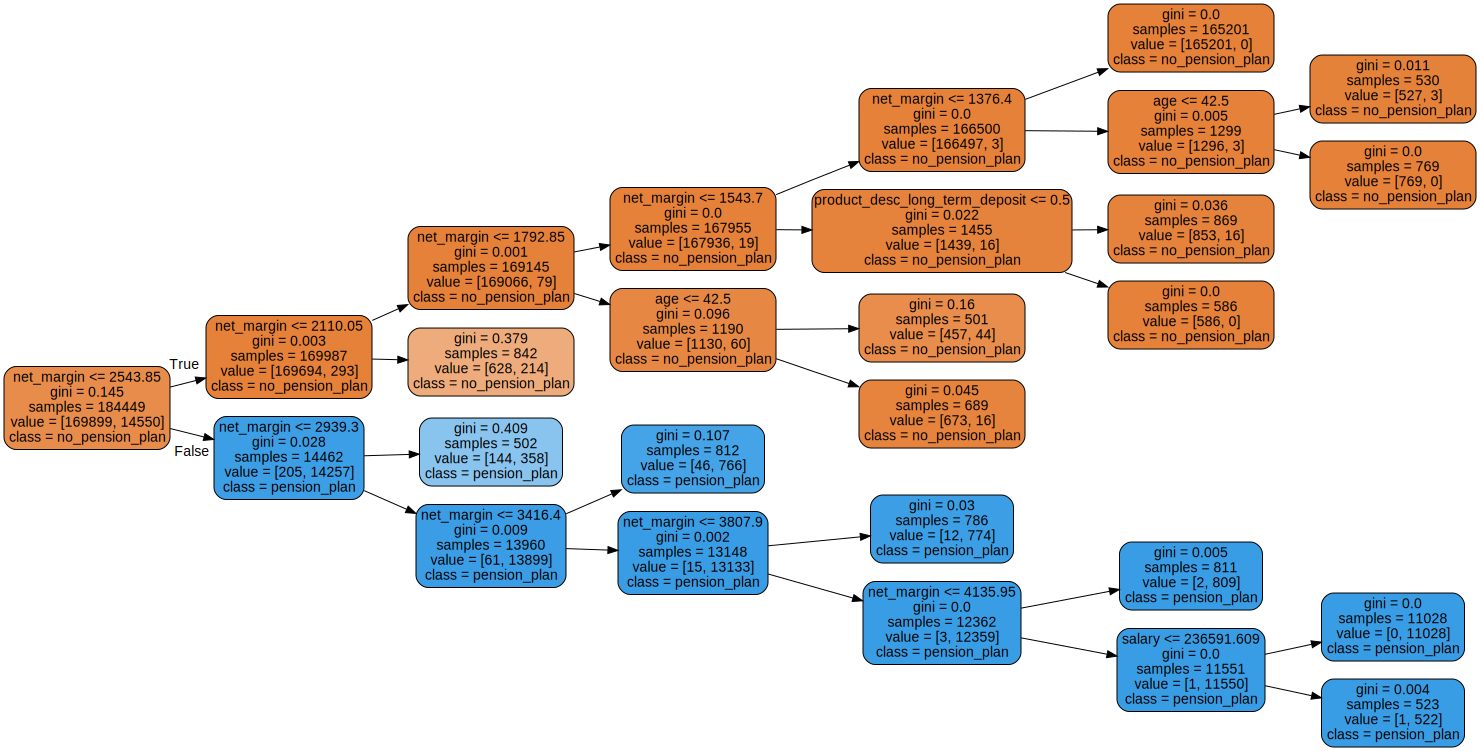

In [237]:
graphviz.Source(tree_data)
# Lo que se aprecia en el arbol es algo en realidad muy intuitivo: para este TARGET lo más distintivo es el net_margin que ofrece, ya que está muy por encima del resto de productos de EasyMoney

In [238]:
#generamos predicciones y evaluamos el modelo
y_test_pred = pd.DataFrame(dt.predict(X_test),index=y_test.index,columns=['pension_plan_prediction'])

In [239]:
#join de y_test y y_test_pred para comparar el resultado real con la predicción
result_df=y_test.join(y_test_pred,how='inner')

In [240]:
result_df['Success']=(result_df['product_desc_pension_plan']==result_df['pension_plan_prediction']).astype(int)

In [241]:
result_df.head(20)

,,product_desc_pension_plan,pension_plan_prediction,Success
sale_ID,customer_ID,,,
227020,1509541,0,0,1
158348,1407427,0,0,1
22099,1405557,0,0,1
172886,1426692,0,0,1
71738,1387953,0,0,1
229652,1514593,0,0,1
32508,1333601,0,0,1
35110,1386834,0,0,1
12789,1391929,0,0,1


In [242]:
#Accuracy
result_df['Success'].mean()

0.9976362414069785

In [ ]:
# El modelo más tonto predicirá con un 92% de accuracy, frente al nuestro que predice con un accuracy 99.76%. NOT BAD


## Confusion matrix

In [244]:
confusion_matrix=pd.crosstab(result_df['product_desc_pension_plan'],result_df['pension_plan_prediction'])

In [264]:
TP=confusion_matrix.iloc[1,1]
TN=confusion_matrix.iloc[0,0]
FP=confusion_matrix.iloc[0,1]
FN=confusion_matrix.iloc[1,0]

In [245]:
confusion_matrix
# Parece que el modelo tiende a dar más falsos negativos, pero aproximadamente está  balanceado entre FP y FN

pension_plan_prediction,0,1
product_desc_pension_plan,,
0,42466,45
1,64,3538


In [246]:
dt.score(X_test,y_test)

0.9976362414069785

In [257]:
#generamos las predicciones del dataset de test pero como probabilidades
dt.predict_proba(X_test)


array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]])

In [258]:
#seleeciono las probabilidades de #1 y lo convierto en un dataframe
y_score= pd.DataFrame(dt.predict_proba(X_test)[:,1],index=y_test.index, columns=['pension_plan_score']).sort_values(by='pension_plan_score', ascending=False)

In [260]:
y_score

,,pension_plan_score
sale_ID,customer_ID,
53558,1381208,1.0
57404,1460405,1.0
50310,1295912,1.0
41661,1000896,1.0
60468,1541065,1.0
...,...,...
95301,1088514,0.0
77700,1523700,0.0
79840,1066061,0.0


In [259]:
# lo combino con el dataframe anterior
result_df= result_df.join(y_score)

ValueError: ignored

In [ ]:
result_df.sort_values(by='pension_plan_score', ascending=False)

## F1 Score

In [265]:
# Desarrollo matemático de F1Score
Precision=TP/ (TP+FP)
Recall= TP/(TP+FN)
f1_score=2/(1/Precision+1/Recall)

In [266]:
# Precision = Cuántos positivos de los que detecta realmente lo son 
# Recall alta = Cuántos positivos detecta el modelo del total

In [267]:
Precision

0.98744069215741

In [268]:
Recall

0.9822320932815103

In [269]:
metrics.f1_score(y_test,y_test_pred)

0.984829505915101

## AUC y ROC curve

In [270]:
metrics.roc_auc_score(result_df['product_desc_pension_plan'],result_df['pension_plan_score'])

0.9999033336389233

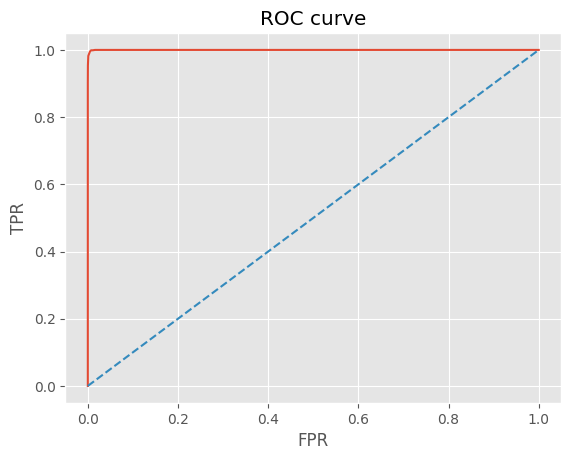

In [271]:
fpr,tpr,th=metrics.roc_curve(result_df['product_desc_pension_plan'],result_df['pension_plan_score'])
plt.plot(fpr,tpr)
plt.plot([0,1],[0,1],linestyle='--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve')
plt.show()


## Control del overfitting

In [275]:
for i in range(1,15):
  #instancio el modelo
  dt2= DecisionTreeClassifier(max_depth=i,random_state=42)
  #entreno el modelo
  dt2.fit(X_train,y_train)
  #evaluo 
  acc_train = dt2.score(X_train,y_train)
  acc_test = dt2.score(X_test,y_test)
  print(f'Profundidad de arbol: {i}, Acc.train: {np.round(acc_train,6)},Acc.test: {np.round(acc_test,6)}')

Profundidad de arbol: 1, Acc.train: 0.9973,Acc.test: 0.997636
Profundidad de arbol: 2, Acc.train: 0.998374,Acc.test: 0.998569
Profundidad de arbol: 3, Acc.train: 0.999528,Acc.test: 0.999588
Profundidad de arbol: 4, Acc.train: 0.999892,Acc.test: 0.999913
Profundidad de arbol: 5, Acc.train: 0.999951,Acc.test: 0.999957
Profundidad de arbol: 6, Acc.train: 0.999995,Acc.test: 1.0
Profundidad de arbol: 7, Acc.train: 1.0,Acc.test: 1.0
Profundidad de arbol: 8, Acc.train: 1.0,Acc.test: 1.0
Profundidad de arbol: 9, Acc.train: 1.0,Acc.test: 1.0
Profundidad de arbol: 10, Acc.train: 1.0,Acc.test: 1.0
Profundidad de arbol: 11, Acc.train: 1.0,Acc.test: 1.0
Profundidad de arbol: 12, Acc.train: 1.0,Acc.test: 1.0
Profundidad de arbol: 13, Acc.train: 1.0,Acc.test: 1.0
Profundidad de arbol: 14, Acc.train: 1.0,Acc.test: 1.0


In [276]:
#puedo probar con diferent numero de observaciones en el nodo final
for i in range(1,15):
  dt2= DecisionTreeClassifier(max_depth=i,random_state=42,min_samples_split=500)
  dt2.fit(X_train,y_train)
  acc_train = dt2.score(X_train,y_train)
  acc_test = dt2.score(X_test,y_test)


  print(f'Profundidad de arbol: {i}, Acc.train: {np.round(acc_train,6)},Acc.test: {np.round(acc_test,6)}')

Profundidad de arbol: 1, Acc.train: 0.9973,Acc.test: 0.997636
Profundidad de arbol: 2, Acc.train: 0.998374,Acc.test: 0.998569
Profundidad de arbol: 3, Acc.train: 0.999528,Acc.test: 0.999588
Profundidad de arbol: 4, Acc.train: 0.999848,Acc.test: 0.99987
Profundidad de arbol: 5, Acc.train: 0.999902,Acc.test: 0.999913
Profundidad de arbol: 6, Acc.train: 0.999913,Acc.test: 0.999913
Profundidad de arbol: 7, Acc.train: 0.999913,Acc.test: 0.999913
Profundidad de arbol: 8, Acc.train: 0.999913,Acc.test: 0.999913
Profundidad de arbol: 9, Acc.train: 0.999913,Acc.test: 0.999913
Profundidad de arbol: 10, Acc.train: 0.999913,Acc.test: 0.999913
Profundidad de arbol: 11, Acc.train: 0.999913,Acc.test: 0.999913
Profundidad de arbol: 12, Acc.train: 0.999913,Acc.test: 0.999913
Profundidad de arbol: 13, Acc.train: 0.999913,Acc.test: 0.999913
Profundidad de arbol: 14, Acc.train: 0.999913,Acc.test: 0.999913


## Modelos alternativos

In [277]:
from sklearn.ensemble import RandomForestClassifier

In [278]:
#Random Forest con 10 replicas
rf = RandomForestClassifier (max_depth=11,random_state=42,min_samples_split=500,n_estimators=10)

In [279]:
rf.fit(X_train,y_train)

<ipython-input-279-d6d9475b85dc>:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train,y_train)


RandomForestClassifier(max_depth=11, min_samples_split=500, n_estimators=10,
                       random_state=42)

In [280]:
rf.score(X_test,y_test)
# El random forest mejora bastante le modelo, de un 99.76% de acierto a un 99.96%

0.9995662828269686

In [283]:
rf.score(val_df_X,val_df_y)

0.9993144647928704

## Variables más predictivas

In [281]:
top_features = pd.Series(rf.feature_importances_, index=X_train.columns).sort_values(ascending=False).head(20)

In [282]:
top_features
# Aquí vemos las variables que el modelo ha considerado como más predictivas

net_margin                         0.575655
family_product_account             0.126505
family_product_payment_card        0.066479
product_desc_short_term_deposit    0.024688
product_desc_em_acount             0.023052
product_desc_long_term_deposit     0.021945
family_product_investment          0.016874
em_acount                          0.015283
product_desc_payroll               0.014179
product_desc_credit_card           0.013691
partition_month                    0.013111
debit_card                         0.012661
payroll                            0.012056
product_desc_debit_card            0.011048
partition_year                     0.007617
product_desc_securities            0.006488
product_desc_payroll_account       0.005321
entry_channel_KHQ                  0.004869
entry_year                         0.004572
age                                0.004443
dtype: float64